This notebook performs the quadratic regression UQ, but with the blackbox optimizer instead of the gradient-based optimizer.

In [1]:
from functools import partial
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

sys.path.insert(0, '../')

# uq4k modules
from uq4k.blackbox.bb_optimizer import BbOpt
from uq4k.models.loss import MeritFunc
from uq4k.plotting.pred_prey import plot_dyn_and_data
from uq4k.models.predprey_model import PredPrey

plt.style.use("seaborn-white")

# Generate Data

In [2]:
def model(theta, x):
    """
    Creates the noise free observation at x
    """
    x_vec = x ** np.array([0, 1, 2])
    
    return np.dot(theta, x_vec)

def generate_data(
    theta,
    num_data,
    noise_mean,
    noise_var,
    x_seed=0,
    noise_seed=1
):
    """
    Generate data with IID gaussian noise with the quadratic model
    defined above.
    
    NOTE: the bounds of the x-value data generate are hard-coded.
    
    Parameters:
    -----------
        theta      (np arr) : true parameter value
        num_data   (int)    : number of data draws
        noise_mean (float)  : use 0 for unbiased noise
        noise_var  (float)  : noise variance
        x_seed     (int)    : random seed for generating x values
        noise_seed (int)    : random seed for noise generation
    
    Returns:
    --------
        x_s (np arr) : array of sampled x values
        y   (np arr) : array of outputs (func + noise)
    
    """
    # random x-values
    np.random.seed(x_seed)
    x_s = stats.uniform(loc=0, scale=5).rvs(num_data)
    
    # generate noise
    np.random.seed(noise_seed)
    noise = stats.norm(loc=noise_mean, scale=np.sqrt(noise_var)).rvs(num_data)
    
    # map points according to model and add noise
    y = np.zeros_like(x_s)
    for i in range(num_data):
        y[i] = model(x=x_s[i], theta=theta) + noise[i]
        
    return x_s, y

In [3]:
# generate data -- using values from overleaf
THETA = np.array([1, 0.5, 1.0])
NOISE_MEAN = 0
SIGMA2 = 0.1
NUM_DATA = 100

# generate data
x_s, y = generate_data(
    theta=THETA,
    num_data=NUM_DATA,
    noise_mean=NOISE_MEAN,
    noise_var=SIGMA2
)

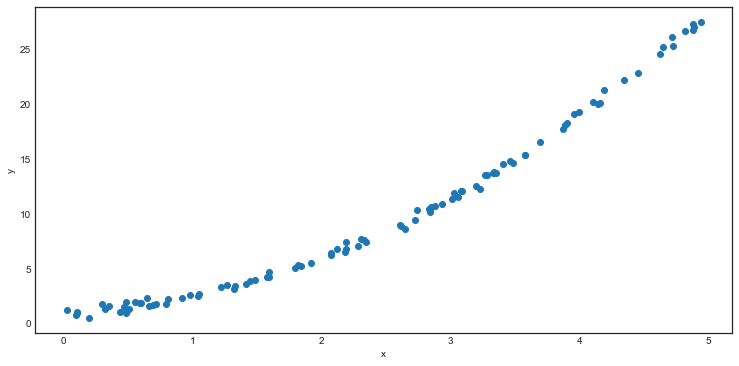

In [4]:
plt.figure(figsize=(12.5,6))
plt.scatter(x_s, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Optimize with identity map as the QoI

In [5]:
# define the QoI to simply be the identity map
id_map = lambda theta: theta

In [6]:
# set optimization parameters
EPSILON = 0.0001                   # stopping criterion for odad_min_e_ball algo
CONF_LEV = 0.95                    # 1 - beta_alpha - i.e., prob not violating
THETA_INIT = np.array([0, 0, 0])   # starting point for MLE optimization
MU = 1e13                          # strength of penalty
BOUNDS = [[-5, 5]] * 3             # variable bounds for diff evol algo
MAX_IT = 10                        # controls number of steps in ball algo

In [7]:
def forward_model(theta, x=x_s):
    """
    Forward model version of the above model() where the
    data are assumed
    """
    N = x.shape[0]
    y = np.zeros(N)
    for i in range(N):
        y[i] = model(x=x[i], theta=theta)

    return y

In [8]:
# create objective function and optimizer objects
objective_obj = MeritFunc(
    forward_model=forward_model, 
    mu=MU, 
    data=y,
    qoi_func=id_map
)
optimizer = BbOpt(objective_obj=objective_obj)

# perform the optimization
mle_theta, M_alpha, S, center, radius_0 = optimizer.optimize_min_e_ball(
    sigma_2=SIGMA2,
    data=y,
    theta_init=THETA_INIT,
    epsilon_0=EPSILON,
    conf_lev=CONF_LEV,
    man_delta=None,
    bounds=BOUNDS,
    max_iter=MAX_IT,
)

print("----- Center and Radius -----")
print(S)
print(center)
print(radius_0)

# perform optimization to find dirac weights
p_opt = optimizer.weight_optimization(S=S)
print("----- Dirac Weights -----")
print(p_opt)

----- Center and Radius -----
[[1.07864257 0.46569232 1.00281984]
 [1.31425249 0.24387838 1.04287004]
 [0.84376395 0.6882042  0.96271226]
 [0.84459544 0.68911165 0.96213002]]
[1.07942397 0.46649502 1.00250003]
0.32608639725069416
----- Dirac Weights -----
[-1.59334575e-09  5.00000317e-01  2.43848434e-01  2.56151252e-01]


# Optimize with a 1d Projection

In [9]:
# define a projection for the QoI
proj_func = lambda theta: theta[0]

In [10]:
# set optimization parameters
EPSILON = 0.0001                   # stopping criterion for odad_min_e_ball algo
CONF_LEV = 0.95                    # 1 - beta_alpha - i.e., prob not violating
THETA_INIT = np.array([0, 0, 0])   # starting point for MLE optimization
MU = 1e13                          # strength of penalty
BOUNDS = [[-5, 5]] * 3             # variable bounds for diff evol algo
MAX_IT = 10                        # controls number of steps in ball algo

In [11]:
# create objective function and optimizer objects
objective_obj = MeritFunc(
    forward_model=forward_model, 
    mu=MU, 
    data=y,
    qoi_func=proj_func
)
optimizer = BbOpt(objective_obj=objective_obj)

# perform the optimization
mle_theta, M_alpha, S, center, radius_0 = optimizer.optimize_min_e_ball(
    sigma_2=SIGMA2,
    data=y,
    theta_init=THETA_INIT,
    epsilon_0=EPSILON,
    conf_lev=CONF_LEV,
    man_delta=None,
    bounds=BOUNDS,
    max_iter=MAX_IT,
)

print("----- Center and Radius -----")
print(S)
print(center)
print(radius_0)

# perform optimization to find dirac weights
p_opt = optimizer.weight_optimization(S=S)
print("----- Dirac Weights -----")
print(p_opt)

----- Center and Radius -----
[1.07864257 0.8355618  1.32184116 0.83543784]
1.0786394959291639
0.24320165976535024
----- Dirac Weights -----
[7.60610235e-10 2.35648031e-01 5.00003597e-01 2.64348372e-01]
